In [6]:
############################################################
# Code prepared by Damien Depannemaecker and Mallory Carlu #
# associated to the figure 2(d) of the paper entitled:     #
# Seizure-like propagation in spiking network models       #
############################################################

from brian2 import *
import numpy as np
from datetime import datetime

#function use firing rate calculation
# array表示在一个特定时间内的激活时间
# bin表示时间间隔，
# time_array表示时间序列，里面是每个时间点的时间，
def bin_array(array, BIN, time_array):
    # N0表示每个bin内的时间点个数
    N0 = int(BIN/(time_array[1]-time_array[0]))
    # N1表示在整个time_array以内，所包含的Bin的数目
    N1 = int((time_array[-1]-time_array[0])/BIN)
    # 返回一个序列内激活次数的平均值
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)

In [7]:
Nseed=1
NAmp=1
NbS=1
NbSim=NbS
Nsim=NbS
# 设置随机数种子，同时开启新的作用域
seed(Nseed)
start_scope()
# 设计模拟时间的步长以及对应的神经元个数
DT=0.1
defaultclock.dt = DT*ms
N1 = 2000#2000
N2 = 8000#8000
# 设置模拟时间
TotTime=4000
duration = TotTime*ms
# 描述膜外电压v与时间t的关系,其中包含电导GsynE,GsynI的许多关系，这里对应论文里面的公式（1），单位为伏特
# dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
# 这里的w大概对应神经元的适应程度
# dw/dt = (a*(v-El)-w)/tau_w:ampere
# 这里表述两个电导随时间变化的关系（单位是西门子）
# GsynI: 抑制性输入的权重；GsynE: 兴奋性输入的权重
# dGsynI/dt = -GsynI/Tsyn : siemens
# dGsynE/dt = -GsynE/Tsyn : siemens
# 后面是很多其余对应的参数单位
# Is:ampere
# Cm:farad
# gl:siemens
# El:volt
# a:siemens
# tau_w:second
# Dt:volt
# Vt:volt
# Ee:volt
# Ei:volt
# Tsyn:second   
# equation of the AdEx Model with "conductance-based" model of synapses 
eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''#% neuron_params
# Populations----------------------------------------------------------------------------------
# 这里依据之前建立的Adex模型来构建完整的神经元网络，其中FS表示抑制性的神经元，RS为兴奋性的神经元
# Population 1 - FS
b1 = 0.0*pA
# eqs表示神经元的动态方程，threshold表示神经元被触发的阈值，reset表示神经元被重置的值，refractory表示神经元的不应期，method表示使用的积分方式
G1 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#init（初始化）:
# 初始化电位
G1.v = -65*mV
# 初始化自适应参数
G1.w = 0.0*pA
# 抑制性输入的权重与兴奋性输入的权重初始化
G1.GsynI=0.0*nS
G1.GsynE=0.0*nS
#parameters
# 这里是神经元的参数设置
# 膜电容
G1.Cm = 200.*pF
# 漏电流上的电导
G1.gl = 10.*nS
# 静息电位
G1.El = -65.*mV
# 电位兴奋阈值
G1.Vt = -48.*mV
# 膜电位动态阈值
G1.Dt = 0.5*mV
# 自适应变量时间常数
G1.tau_w = 1.0*ms
# 自适应系数
G1.a = 0.0*nS
# 外部突触输入输入
G1.Is = 0.0 
# 兴奋性输入
G1.Ee=0.*mV
# 抑制性输入
G1.Ei=-80.*mV
# 传递延迟
G1.Tsyn=5.*ms
# Population 2 - RS
b2 = 100.*pA
G2 = NeuronGroup(N2, eqs, threshold='v > -40.*mV', reset='v = -65*mV; w += b2', refractory='5*ms',  method='heun')
G2.v = -65.*mV
G2.w = 0.0*pA
G2.GsynI=0.0*nS
G2.GsynE=0.0*nS
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -65.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 1000.*ms
G2.a = 0.*nS
G2.Is = 0.0*nA 
G2.Ee=0.*mV
G2.Ei=-80.*mV
G2.Tsyn=5.*ms
# external drive and seizure-like perturabation----------------------------------------------
# AmpStim输入刺激的强度
AmpStim=NAmp*5.+60  #80. #92.
# 输入刺激的持续平台期
plat = 1000
def heaviside(x):
    return 0.5 * (1 + np.sign(x))
# 定义相应的输入脉冲
# 这里的脉冲函数的表达式不太清楚具体原理（主要目的就是输入脉冲）
def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
        # t1_exc=10. # time of the maximum of external stimulation
        # tau1_exc=20. # first time constant of perturbation = rising time
        # tau2_exc=50. # decaying time
        # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      heaviside(-(t - (t1_exc+plateau))) * heaviside(t - (t1_exc))+ \
                      np.exp(-(t - (t1_exc+plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc+plateau)))
    return inp
# 创建仿真时间序列
t2 = np.arange(0, TotTime, DT)
test_input = []
# 输入的噪声强度
TauP=20.+8*NbS
# 将时间点，噪声，输入刺激，输入刺激的平台期产生对应时间的脉冲
for ji in t2:
    test_input.append(6.+input_rate(ji, 2000., TauP, TauP, AmpStim, plat))

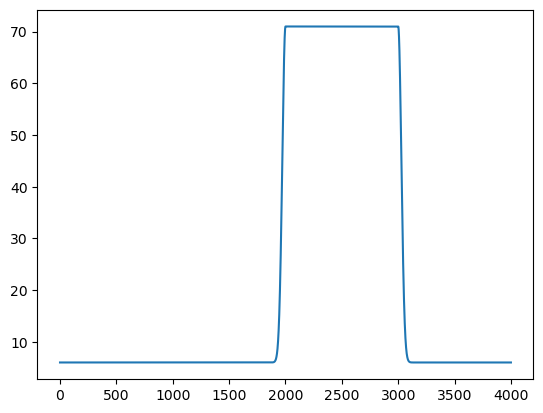

In [8]:
BIN=10
time_array = np.arange(int(TotTime/DT))*DT
import matplotlib.pyplot as plt
plt.plot(time_array, test_input)

In [9]:
# 创建一个时间序列的脉冲充当刺激
stimulus=TimedArray(test_input*Hz, dt=DT*ms)
# 创建神经元组
P_ed=PoissonGroup(8000, rates='stimulus(t)') #, dt=0.01*ms)
# connections-----------------------------------------------------------------------------
# 单位是n西门子
Qi=5.0*nS
Qe=1.5*nS
# 神经元之间互连的概率
prbC= 0.05 #0.05
prbC2= 0.05 #0.065
# 创建G1到G2之间神经元的突触，命名为S_12
# G1是抑制性的，G2是兴奋性的
# 这里的on_pre表示当前突触神经元发生后，后突触神经元电导将增加Qi
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
# 神经元之间不自连，连接的概率为prbC
S_12.connect('i!=j', p=prbC)
S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC)
# 这里的on_pre表示当前突触神经元发生后，后突触神经元电导将增加Qe
S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)
S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)
# 这里是G1到P_ed的突触，命名为S_ed_in
# 一但前面的神经元发出了动作电位，后面的神经元的电导将增加Qe
S_ed_in = Synapses(P_ed, G1, on_pre='GsynE_post+=Qe')
S_ed_in.connect(p=prbC2)
# 这里是G2到P_ed的突触，命名为S_ed_ex
S_ed_ex = Synapses(P_ed, G2, on_pre='GsynE_post+=Qe')
S_ed_ex.connect(p=prbC)#0.05)
# monitor tools to record during simulation-------------------------------------------------
# 建立监视器用于记录数据
#FRG1 = PopulationRateMonitor(G1)
# 建立monitor来记录神经元动作电位的发放率
FRG2 = PopulationRateMonitor(G2)
FRPed= PopulationRateMonitor(P_ed)


In [10]:
# # Run the simulation ----------------------------------------------------------------------
# # Sim表示本次仿真的序列
# Sim=(Nseed+1)*(NAmp+1)*(NbS+1)
# print("Starts Time:", datetime.now())
# print('Starts simulation #'+str(Sim))
# run(duration)
# print('Ends simulation #'+str(Sim))
# print("Ends Time:", datetime.now())
# # Prepare and save data---------------------------------------------------------------------

#LfrG1=np.array(FRG1.rate/Hz)
#TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)
# LfrG2=np.array(FRG2.rate/Hz)
# bin_array将序列分组并计算每组的平均值
# TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)
# LfrPed=np.array(FRPed.rate/Hz)
# TimBinned,popRatePed=bin_array(time_array, BIN, time_array),bin_array(LfrPed, BIN, time_array)
# np.save('Seizure_Ref/Results2/AD_popRateExc_Sim_'+str(TauP)+'_Amp_'+str(NAmp)+'Nseed_'+str(Nseed)+'.npy', popRateG2)

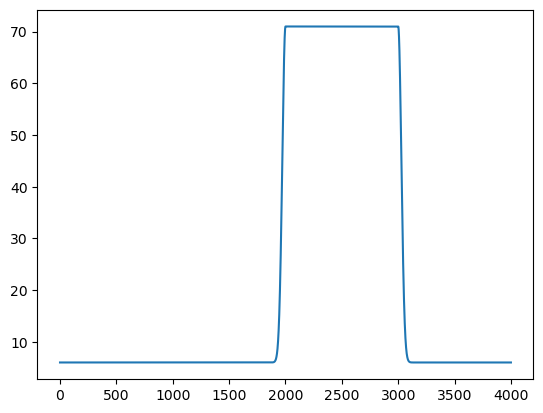

In [11]:
BIN=10
time_array = np.arange(int(TotTime/DT))*DT
import matplotlib.pyplot as plt
plt.plot(time_array, test_input)

In [12]:
test_input=np.array(test_input)